Importing Kagglehub for the dataset

Let's see where the dataset has been downloaded.

Import the necessary libraries

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "2"
os.environ["TF_NUM_INTRAOP_THREADS"] = "2"
os.environ["TF_NUM_INTEROP_THREADS"] = "2"

import tensorflow as tf
tf.config.threading.set_intra_op_parallelism_threads(2)
tf.config.threading.set_inter_op_parallelism_threads(2)


2026-02-03 10:49:30.551507: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-03 10:49:31.663709: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-03 10:49:35.571224: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from pathlib import Path

DATA_ROOT = Path("/leonardo_scratch/fast/tra26_castiel2/data/kaggle_kermany2018/OCT2017")
train_path = DATA_ROOT / "train"
val_path   = DATA_ROOT / "val"
test_path  = DATA_ROOT / "test"

print(train_path.exists(), val_path.exists(), test_path.exists())

True True True


In [3]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

2026-02-03 13:16:45.722962: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-03 13:16:46.854477: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-03 13:16:51.058011: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
categories = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# EDA: Count number of images per category in each set
def count_images_in_directory(directory):
    category_count = {}
    for category in categories:
        category_path = os.path.join(directory, category)
        category_count[category] = len(os.listdir(category_path))
    return category_count

# Get image distribution for train, validation, and test sets
train_distribution = count_images_in_directory(train_path)
test_distribution = count_images_in_directory(test_path)
val_distribution = count_images_in_directory(val_path)

1. What Is Class Imbalance?
🔍 Definition:
Class imbalance happens when some categories in your dataset have many more samples than others.


If you look at the distribution of OCT images (via bar charts), you might see:



*   37,000 CNV images
*   3,000 DRUSEN images
*   11,000 DME images
*   26,000 NORMAL images

So:

CNV and NORMAL are majority classes

DRUSEN is a minority class

2. Why Is Class Imbalance a Problem?

 From the model's point of view:
A CNN is trained to minimize error. If CNV appears more often, the model learns to prioritize CNV — even when it sees DRUSEN or DME.

  What this means in diagnosis:
A model may misdiagnose DRUSEN as CNV or NORMAL — simply because it wasn’t trained with enough DRUSEN examples.

**In healthcare, false negatives (missing a disease) can be dangerous.**

3. Imagine you train a medical student with 100 patients — 80 have CNV, only 5 have DRUSEN.
They become great at spotting CNV, but they miss DRUSEN cases because they rarely see them.

This is class imbalance in real life — and we must correct for it.

4. How to handle class imbalance:

  1.  Data Augmentation for Minority Classes: ImageDataGenerator is already used for real-time augmentation.

This can help artificially boost the presence of DRUSEN and DME images by creating slightly modified copies (rotated, zoomed, flipped).

Example:



```
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
```



✅ Best for image datasets. Prevents overfitting and balances class exposure.

  2. Class Weights (Model Penalization): You can tell the model to pay more attention to underrepresented classes.

Add class_weight in model.fit() like:



```
class_weights = {
    0: 1.0,  # CNV
    1: 1.0,  # DME
    2: 2.5,  # DRUSEN (boosted)
    3: 1.0   # NORMAL
}
```

```
model.fit(train_generator,
          validation_data=val_generator,
          epochs=10,
          class_weight=class_weights)

```

✅ Helps the model treat minority classes seriously.


In [5]:
import os

categories = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# Function to count images in a given directory
def count_images_in_directory(directory):
    category_count = {}
    for category in categories:
        category_path = os.path.join(directory, category)
        if os.path.exists(category_path):
            category_count[category] = len(os.listdir(category_path))
        else:
            category_count[category] = 0  # If folder is missing
    return category_count

# Run counts
train_distribution = count_images_in_directory(train_path)
val_distribution = count_images_in_directory(val_path)
test_distribution = count_images_in_directory(test_path)

# Display results
print("Train set distribution:", train_distribution)
print("Validation set distribution:", val_distribution)
print("Test set distribution:", test_distribution)

Train set distribution: {'CNV': 37205, 'DME': 11348, 'DRUSEN': 8616, 'NORMAL': 26315}
Validation set distribution: {'CNV': 8, 'DME': 8, 'DRUSEN': 8, 'NORMAL': 8}
Test set distribution: {'CNV': 242, 'DME': 242, 'DRUSEN': 242, 'NORMAL': 242}


In [6]:
from PIL import Image
import os

# Alege o imagine dintr-o categorie, de exemplu CNV
sample_image_path = os.path.join(train_path, 'DME', os.listdir(os.path.join(train_path, 'DME'))[0])

# Deschide imaginea
img = Image.open(sample_image_path)

# Afișează dimensiunea
print("Image dimension:", img.size)  # (width, height)


Image dimension: (768, 496)


/tmp/ipykernel_2356305/2367306795.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(train_distribution.keys()), y=list(train_distribution.values()), palette="Blues")
/tmp/ipykernel_2356305/2367306795.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(val_distribution.keys()), y=list(val_distribution.values()), palette="Greens")
/tmp/ipykernel_2356305/2367306795.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(test_distribution.keys()), y=list(test_distribution.values()), palette="Reds")


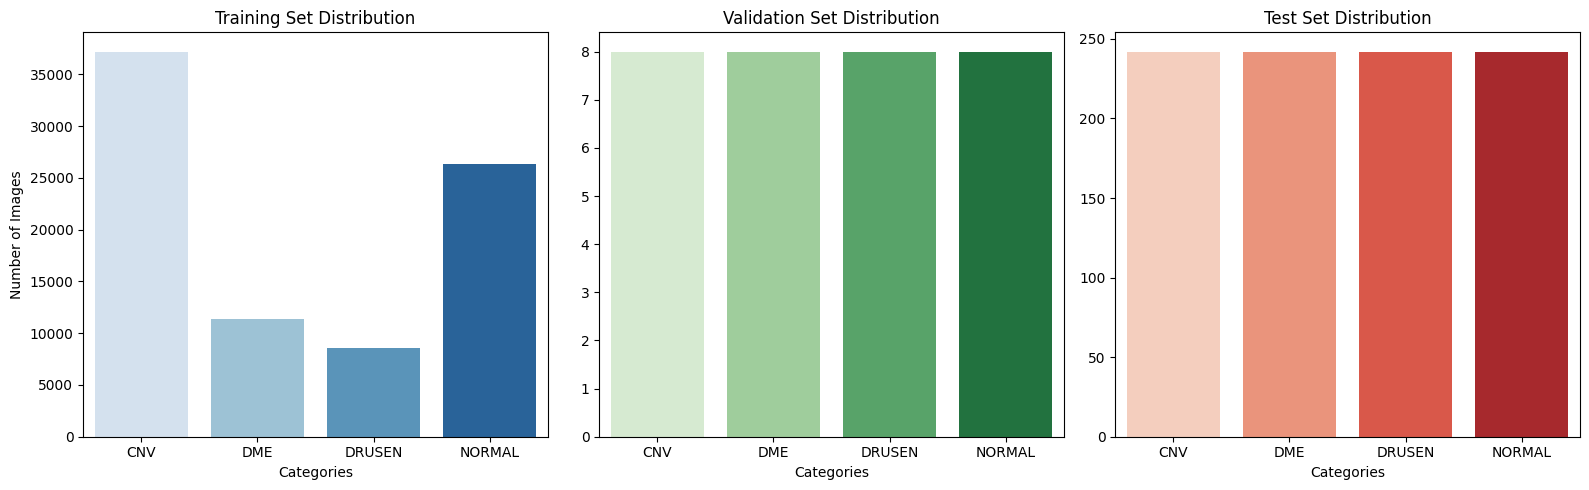

In [7]:
# Plot the distribution of images across categories for train, validation, and test sets
def plot_class_distribution():
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 3, 1)
    sns.barplot(x=list(train_distribution.keys()), y=list(train_distribution.values()), palette="Blues")
    plt.title("Training Set Distribution")
    plt.xlabel("Categories")
    plt.ylabel("Number of Images")

    plt.subplot(1, 3, 2)
    sns.barplot(x=list(val_distribution.keys()), y=list(val_distribution.values()), palette="Greens")
    plt.title("Validation Set Distribution")
    plt.xlabel("Categories")

    plt.subplot(1, 3, 3)
    sns.barplot(x=list(test_distribution.keys()), y=list(test_distribution.values()), palette="Reds")
    plt.title("Test Set Distribution")
    plt.xlabel("Categories")

    plt.tight_layout()
    plt.show()

# Display class distribution plots
plot_class_distribution()

In [8]:
# Image preprocessing using ImageDataGenerator
img_size = (128, 128)
batch_size = 8

**What is a Batch?** When we train a deep learning model, we don’t give it all the data at once. Instead, we break the data into smaller groups called batches.

A batch is a small subset of the dataset that the model processes before updating its weights.

📊 Example:
Let’s say your training set has 10,000 retinal OCT images, and your batch_size is 32.

Instead of training on all 10,000 images at once (which would be slow and require lots of memory), the model takes:

Batch 1: 32 images

Batch 2: next 32 images

...

This continues until all images have been seen once = 1 epoch.

So, for one full training cycle (epoch):

10,000 / 32 = 312.5 batches (the model will process ~313 batches per epoch)

**Why use batches instead of all data?**

  1. Memory Efficiency:
Medical images are large (e.g., 128x128 pixels × 3 channels) and processing 10,000 images at once would exceed your computer’s memory.
Batches keep the memory usage manageable.

  2. Faster Training:
Smaller chunks mean quicker updates (faster iterations).
You don’t have to wait for all 10,000 images to finish before making an update.

  3. More Frequent Learning:
After each batch, the model adjusts its weights based on the loss (error).

This allows it to learn gradually and adapt faster.

**What happens internally for each batch?**

The model does a forward pass:

* It uses its current weights to make predictions on the 32 images.

* It computes the loss:

  * Measures how far off the predictions were from the true labels.

* It does a backward pass (backpropagation):

  * Adjusts its weights slightly to reduce the error.

* Then it moves on to the next batch.

Repeat this for multiple epochs:
Each image in the training set is seen once per epoch, but many times across all epochs (e.g., 10 epochs → each image is seen 10 times in total, in different shuffled batches).


Batch:	A small group of images used to train the model at one time

Batch Size:	Number of images in one batch (here: 32)

Epoch:	One full pass through the entire dataset

Why 32?	It’s a balance between training speed, memory usage, and accuracy stability. Often used as a good default.

In [9]:
# Augmentation and rescaling for training set
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

**Why do we use ImageDataGenerator?**

It’s a powerful Keras utility that automates and simplifies the loading, rescaling, and augmentation of image data during training.

1. Rescaling from [0, 255] → [0, 1] — Why?
The Problem:
- Raw pixel values in digital images range from 0 to 255.

- These are integer values (called uint8 type) and represent color intensity for each pixel.

- Feeding these large values into a neural network slows down training and can lead to unstable gradients.

💡 Neural networks work better when:
- Input values are small and consistent.

- Ideally, values should be in the range:
    [0, 1] (for ReLU activations)

    or sometimes [-1, 1] (for tanh activations)

🧠
In this notebook, you’ll see:

`ImageDataGenerator(rescale=1./255)`
This automatically divides all pixel values by 255, turning this:

`Pixel value = 128` → becomes → `128 / 255 ≈ 0.502`
Now, all inputs lie between 0.0 and 1.0, making them:

* Easier for the model to process.

* More numerically stable during optimization (e.g., when calculating gradients).

* Faster to converge to a solution.


2. What else does ImageDataGenerator do?

Besides rescaling, it also provides real-time data augmentation (if configured), such as:



```
ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
```

This applies random transformations on the fly, such as:

* Rotating OCT scans slightly

* Shifting them sideways or vertically

* Zooming in or out

* Flipping images horizontally


=> It increases data diversity without needing more real scans.

=> Helps prevent overfitting — the model won’t memorize fixed positions or orientations.

=> Mimics real-life variability in how retinal scans are taken (slightly off-center, different zoom levels).

👩‍⚕️ In the context of OCT medical imaging:
Even if you only have 5,000 original scans, augmentation can generate tens of thousands of slightly different views, improving generalization.

In [10]:
# Data Generators
train_generator = train_datagen.flow_from_directory(train_path, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_path, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_path, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


🔍 Purpose:
Automatically:

- Read images from folders.

- Assign labels based on folder names.

- Convert them into batches of tensors.

What is `.flow_from_directory()`?

- Reads images directly from folders, where each folder represents a label (category).

- Applies preprocessing (resizing, scaling, augmentation).

- Sends batches of images + their labels to the neural network — just in time for training.

Why use `.flow_from_directory()`?

- It automatically labels images based on folder names.

- It avoids loading everything into memory (very important for large medical image datasets).

- It integrates perfectly with Keras .fit() method.

- It supports batching, shuffling, and on-the-fly augmentation.

In [11]:
# Build CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

/leonardo/home/userexternal/eparasch/venvs/jlab/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-02-03 13:16:54.217297: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2026-02-03 13:16:54.217852: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2026-02-03 13:16:54.217860: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: 

The structure of the CNN:

* 3 Conv-Pool Blocks to extract features (edges, textures).

* Flatten + Dense layers to classify.

* Dropout to prevent overfitting.

* Softmax → multi-class output for 4 classes.

1. Convolutional Layers (Conv2D) – “Eyes of the Model”

`Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3))`

It applies 32 filters, each of size 3×3, that slide across the image and extract patterns. Each filter “sees” a small part of the image and detects things like:

* Edges

* Curves

* Bright-dark transitions

🔬 In this case: A filter might learn to detect fluid leakage, macular thickness, or drusen spots.

Why multiple filters? Each one learns a different feature.

Activation function: `'relu'`

* ReLU replaces negative numbers with 0 (like turning off weak signals).

* Makes the model non-linear — necessary for learning complex patterns.

Input shape:
`128 x 128 x 3 `— the OCT image is resized to 128×128 pixels, and it has 3 channels (RGB).

2. Pooling Layers (MaxPooling2D) – “Zooming Out”

`MaxPooling2D(2, 2)`

It reduces the size of the feature maps by keeping only the most important values.

For each 2×2 block, it keeps only the maximum value.


Benefits:
Speeds up training; Reduces memory use; Makes the model more robust to image shifts

3. Three Conv–Pool Blocks in Sequence

`Conv2D(32) → MaxPool → Conv2D(64) → MaxPool → Conv2D(128) → MaxPool`

Each block goes deeper into the image features:

Block 1: basic edges, textures

Block 2: patterns of textures (e.g., curved vessels)

Block 3: abstract features (e.g., OCT swelling shapes)

💡 Analogy: going from “pixels” → “features” → “disease signature.”

4. Flatten Layer – “From Image to Vector”

`Flatten()`

It converts the 3D feature maps into a 1D vector so it can be passed into a dense (fully connected) layer.

💡 Analogy: unfolding a brain scan onto a flat report for the doctor to interpret.

5. Dense Layer – “Classifier”

`Dense(128, activation='relu')`

A fully connected layer that uses all learned features to make a decision.

Each neuron learns combinations of features to help classify diseases.

Why 128?
It’s a small, efficient number of units — balances learning power and speed.

6. Dropout Layer – “Forget Some Connections”

`Dropout(0.5)`

It randomly drops (ignores) 50% of neurons during training.

Prevents the model from becoming too dependent on specific features.

💡 Analogy: a medical student being forced to diagnose without relying only on one clue — it trains them to be more general.

Prevents overfitting: where the model memorizes the training images instead of learning general rules.

7. Output Layer with Softmax – “Final Diagnosis”

`Dense(4, activation='softmax')`

It outputs 4 values — one for each class:

CNV, DME, DRUSEN, NORMAL

Softmax converts these values into probabilities that sum to 1.

Example output:

[0.02, 0.15, 0.75, 0.08] → predicted: DRUSEN

Why softmax?
It allows the model to pick the most likely class and it is needed when using categorical_crossentropy as the loss.



In [12]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

1. Adam: efficient optimizer.

Categorical crossentropy: correct loss for one-hot encoded multi-class classification.

What is an optimizer?

The optimizer decides how the model's internal parameters (weights) are updated during training. After the model makes a prediction and calculates the error using the loss function, the optimizer changes the weights to reduce that error in future predictions.

Why Adam?
Adam = Adaptive Moment Estimation.

It combines the advantages of:

* SGD (Stochastic Gradient Descent): updates weights based on small batches.

* Momentum: remembers past gradients to smooth out the updates.

* Adaptive learning rate: adjusts the learning speed for each weight individually.

Why we use it in medical image models:
It’s fast and efficient, especially with large and complex image data like OCT scans. It learns well even with noisy gradients (like from data augmentation).
Good default optimizer — widely used in both research and practice.

2. `loss='categorical_crossentropy'`

🔍 What is a loss function?
The loss function tells the model how wrong its predictions are.

It’s the objective we try to minimize during training.

🧠 Why categorical_crossentropy?

We're doing multi-class classification (4 possible classes: CNV, DME, DRUSEN, NORMAL).

Our labels are one-hot encoded vectors (e.g., [0, 1, 0, 0]).

The model's output is a probability distribution (via softmax), like [0.1, 0.7, 0.1, 0.1].

🚨 How does it work?
categorical_crossentropy compares the predicted probabilities with the true label.

It penalizes the model more when the probability for the correct class is low.

It guides the model to increase confidence in the right class.



In [13]:
# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Parameters are the internal weights and biases of the model — the numbers that the model learns from the data during training.

In a CNN:

* Convolutional layers have filters → each filter has weights.

* Dense (fully connected) layers connect neurons → each connection has a weight.

* Each weight is a trainable parameter.

The model includes Conv2D layer with 32 filters.

Each filter is 3×3 and has 3 input channels (RGB)

So: 32 × (3×3×3 + 1 bias) = 896 parameters

That’s just for the first layer. Later layers (with 64, 128 filters and full Dense layers) have thousands or millions of parameters.

All those together = 3,305,156 parameters

In [14]:
# Model training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    )

Epoch 1/10
10436/10436 ━━━━━━━━━━━━━━━━━━━━ 531s 51ms/step - accuracy: 0.6941 - loss: 0.8051 - val_accuracy: 0.7500 - val_loss: 0.5790
Epoch 2/10
10436/10436 ━━━━━━━━━━━━━━━━━━━━ 429s 41ms/step - accuracy: 0.8155 - loss: 0.5123 - val_accuracy: 0.9375 - val_loss: 0.2490
Epoch 3/10
10436/10436 ━━━━━━━━━━━━━━━━━━━━ 444s 43ms/step - accuracy: 0.8566 - loss: 0.4181 - val_accuracy: 0.9375 - val_loss: 0.2047
Epoch 4/10
10436/10436 ━━━━━━━━━━━━━━━━━━━━ 432s 41ms/step - accuracy: 0.8701 - loss: 0.3857 - val_accuracy: 1.0000 - val_loss: 0.0912
Epoch 5/10
10436/10436 ━━━━━━━━━━━━━━━━━━━━ 429s 41ms/step - accuracy: 0.8758 - loss: 0.3698 - val_accuracy: 0.9688 - val_loss: 0.1089
Epoch 6/10
10436/10436 ━━━━━━━━━━━━━━━━━━━━ 429s 41ms/step - accuracy: 0.8786 - loss: 0.3610 - val_accuracy: 0.9375 - val_loss: 0.1087
Epoch 7/10
10436/10436 ━━━━━━━━━━━━━━━━━━━━ 425s 41ms/step - accuracy: 0.8827 - loss: 0.3511 - val_accuracy: 1.0000 - val_loss: 0.0517
Epoch 8/10
10436/10436 ━━━━━━━━━━━━━━━━━━━━ 445s 43ms/s

Model learns from training data and checks its performance on validation data across 10 epochs (full passes through the dataset).

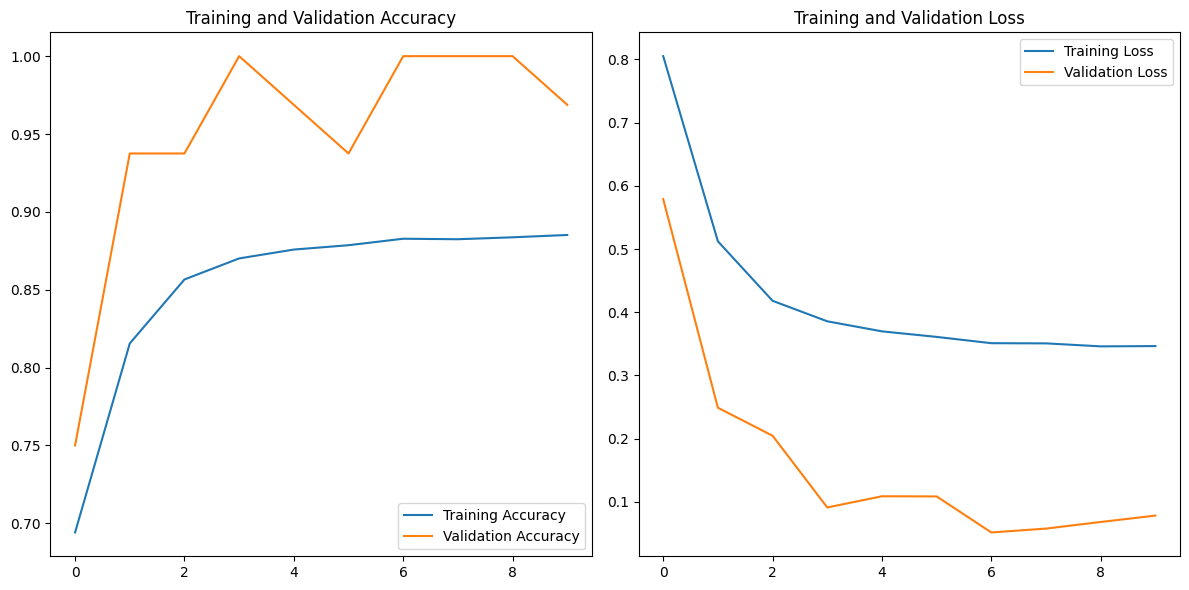

In [15]:
# Learning Curves for Accuracy and Loss
def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

# Plot learning curves
plot_learning_curves(history)

In [16]:
# Evaluate model on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9463 - loss: 0.1387
Test Accuracy: 94.63%


In [17]:
# Predicting on the test set
test_predictions = model.predict(test_generator)
test_predictions_labels = np.argmax(test_predictions, axis=1)
true_labels = test_generator.classes

121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


In [18]:
# Classification report
class_report = classification_report(true_labels, test_predictions_labels, target_names=categories)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

         CNV       0.88      0.96      0.92       242
         DME       0.96      0.93      0.94       242
      DRUSEN       1.00      0.90      0.95       242
      NORMAL       0.96      1.00      0.98       242

    accuracy                           0.95       968
   macro avg       0.95      0.95      0.95       968
weighted avg       0.95      0.95      0.95       968



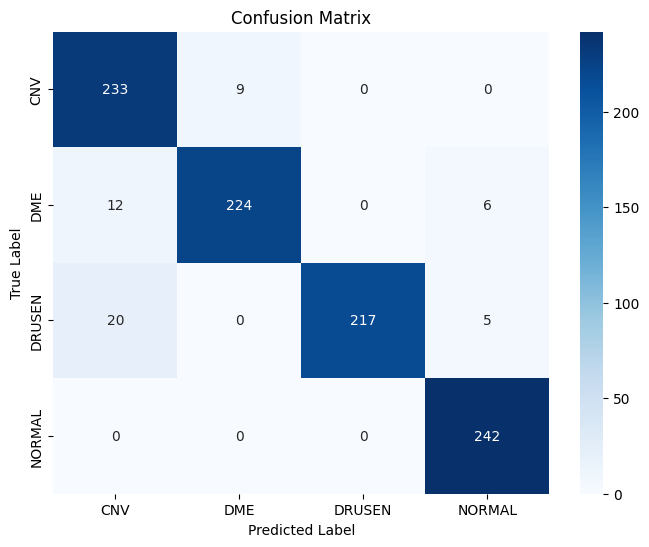

In [19]:
# Confusion matrix
conf_matrix = confusion_matrix(true_labels, test_predictions_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=categories, yticklabels=categories)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

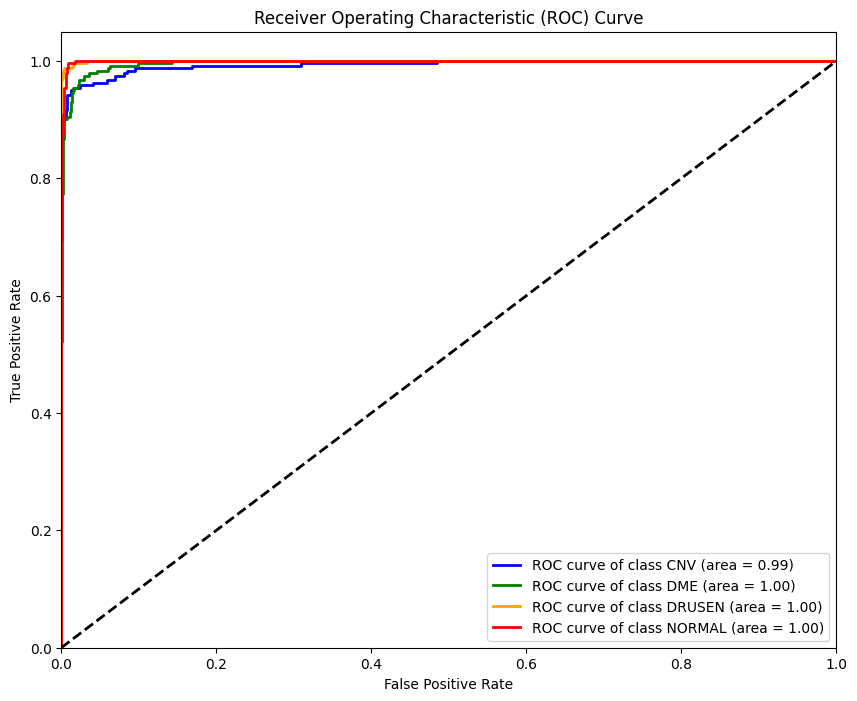

In [20]:
# ROC Curve for Multi-class Classification
def plot_multiclass_roc(test_labels, test_predictions):
    test_labels_binarized = label_binarize(test_labels, classes=[0, 1, 2, 3])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(categories)):
        fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], test_predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i, color in zip(range(len(categories)), ['blue', 'green', 'orange', 'red']):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {categories[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC Curve for multi-class
plot_multiclass_roc(true_labels, test_predictions)

🧠 What is the ROC Curve?
The ROC curve is a plot of:

* True Positive Rate (Sensitivity or Recall)
vs.

* False Positive Rate (1 - Specificity)

It tells us how well the model can distinguish between one class and all the others.

In multi-class classification, we plot one ROC curve per class, by treating each class as “positive” and the others as “negative.”

Why ROC Curves are helpful in Medical Diagnosis?

1. They evaluate more than just accuracy:
A model might show 90% accuracy, but this could be misleading if the dataset is imbalanced (e.g., most images are NORMAL).

  - ROC curves focus on sensitivity (recall), which is critical in medicine:

  - You don’t want the model to miss DRUSEN or CNV, even if they are rare.

2. They show diagnostic ability across thresholds:
The model outputs probabilities, not hard labels.

ROC curves show how performance changes as the decision threshold shifts.

Clinicians may want:

  - High sensitivity → catch as many diseases as possible (for screening tools)

or

  - High specificity → minimize false alarms (for final diagnosis)

3. The AUC (Area Under Curve) gives a clear score:

AUC = 1 → perfect classifier

AUC = 0.5 → random guessing

AUC ≥ 0.90 → excellent model

AUC < 0.70 → weak, needs improvement

So instead of just saying “my model is good,” you can say:

"Our model detects CNV with an AUC of 0.94, which means there's a 94% chance it ranks a true CNV scan higher than a non-CNV scan."

👨‍⚕️ Clinical Perspective:
Imagine your model must detect DRUSEN, a subtle sign of AMD (age-related macular degeneration).

Even if accuracy looks high, a low AUC for DRUSEN might mean:

The model often misses real DRUSEN cases OR confuses them with NORMAL or DME.

The ROC curve helps reveal this hidden diagnostic weakness — and that’s crucial in medicine.

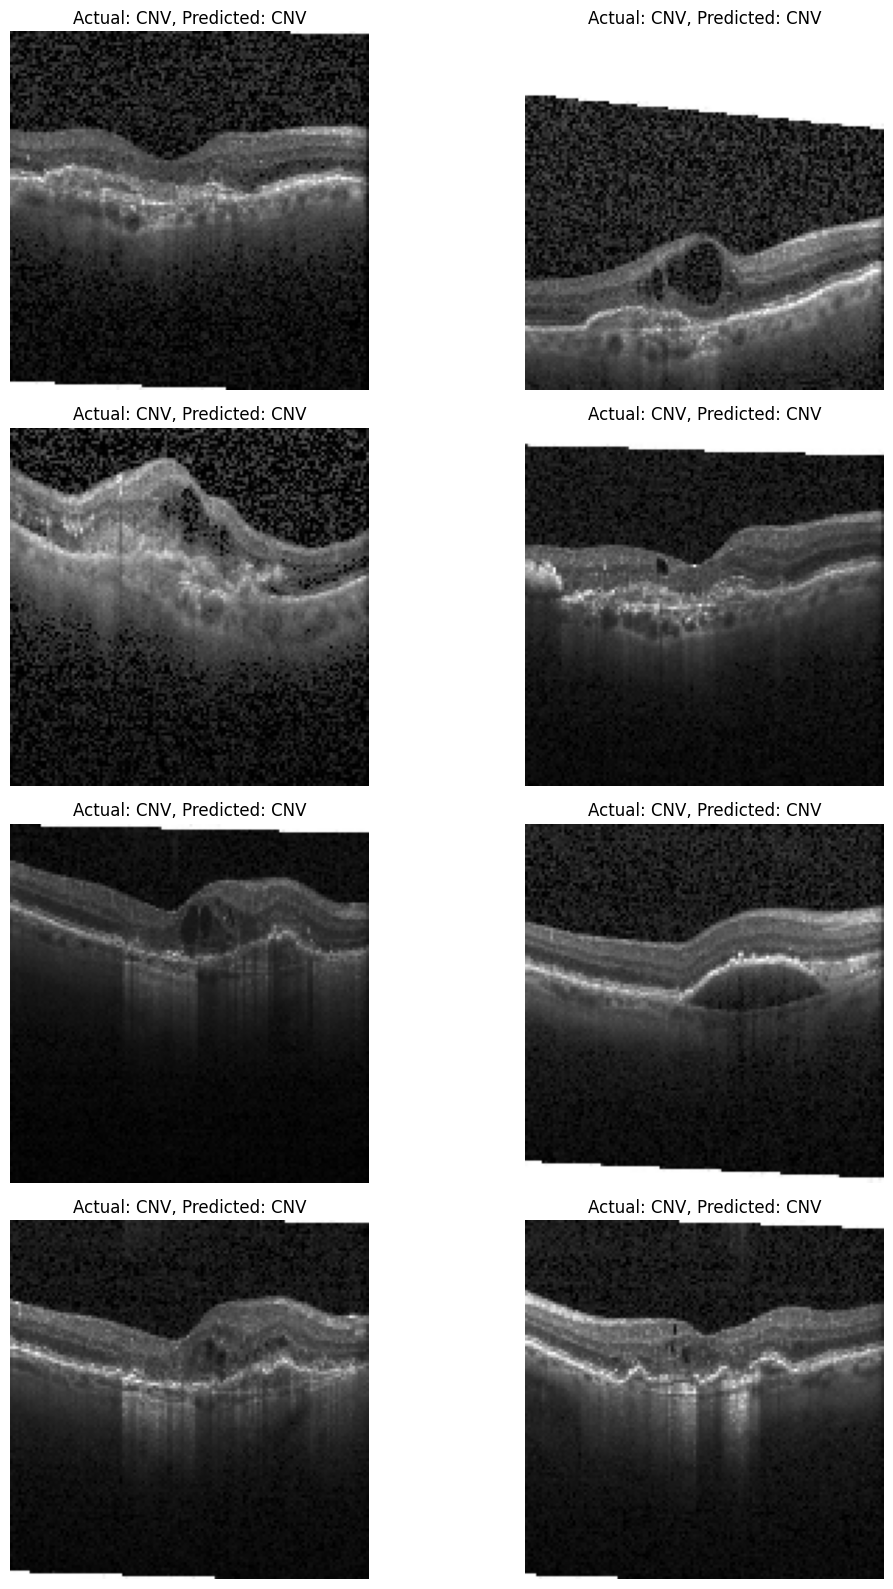

In [22]:
import math
import numpy as np
import matplotlib.pyplot as plt

def plot_sample_predictions(test_generator, num_samples=10, cols=2):
    test_generator.reset()
    sample_images, sample_labels = next(test_generator)   # one batch

    batch_n = sample_images.shape[0]
    num_samples = min(num_samples, batch_n)               # <-- key fix

    predictions = model.predict(sample_images, verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)

    rows = math.ceil(num_samples / cols)
    plt.figure(figsize=(6*cols, 4*rows))

    for i in range(num_samples):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(sample_images[i])
        plt.title(
            f"Actual: {categories[np.argmax(sample_labels[i])]}, "
            f"Predicted: {categories[predicted_labels[i]]}"
        )
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_sample_predictions(test_generator, num_samples=10)


In [23]:
# categories in the exact order used by the generator
idx_to_class = {v: k for k, v in test_generator.class_indices.items()}
categories = [idx_to_class[i] for i in range(len(idx_to_class))]
print("class_indices:", test_generator.class_indices)
print("categories:", categories)

class_indices: {'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}
categories: ['CNV', 'DME', 'DRUSEN', 'NORMAL']


Misclassified: 52 / 968


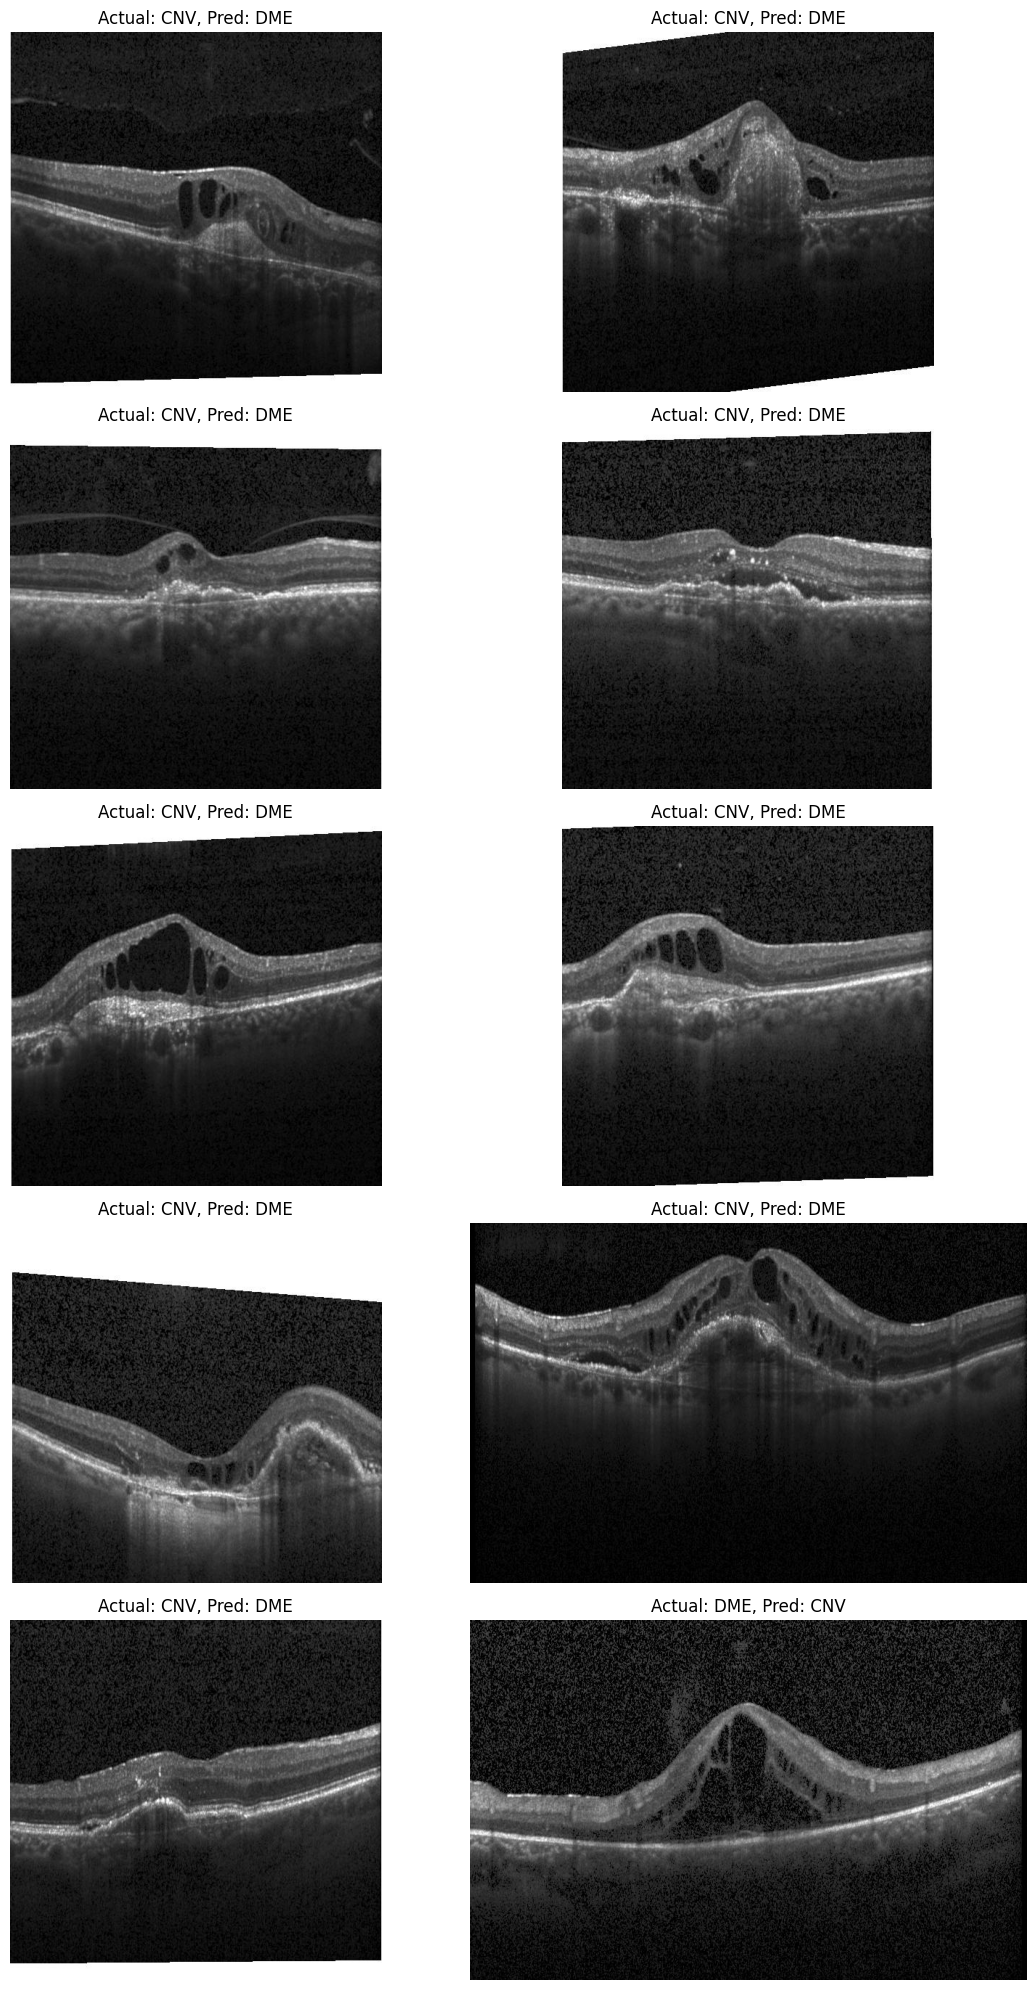

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def plot_misclassifications(gen, max_images=10, cols=2):
    gen.reset()
    preds = model.predict(gen, verbose=0)
    y_pred = np.argmax(preds, axis=1)
    y_true = gen.classes

    mis_idx = np.where(y_true != y_pred)[0]
    print(f"Misclassified: {len(mis_idx)} / {len(y_true)}")

    if len(mis_idx) == 0:
        print("No misclassifications found. Either the model is perfect on this test set, or there may be data leakage / label issues.")
        return

    pick = mis_idx[:min(max_images, len(mis_idx))]
    rows = int(np.ceil(len(pick) / cols))
    plt.figure(figsize=(6*cols, 4*rows))

    for i, k in enumerate(pick):
        img = plt.imread(gen.filepaths[k])
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap="gray" if img.ndim == 2 else None)
        plt.title(f"Actual: {categories[y_true[k]]}, Pred: {categories[y_pred[k]]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_misclassifications(test_generator, max_images=10)


In [ ]:
# Save the model
model.save('/kaggle/working/oct_model.h5')